# *IMPORTANTE: Este cuaderno fue ejecutado en un entorno de kaggle con acceso a una gpu T4. Se muestra aca en el repositorio de github con propositos expositivos*

# Comparación de QML (Angle Embedding) y DNN para b-Tagging en Jets usando Archivos ROOT

## Introducción
Este notebook implementa un flujo de trabajo para comparar modelos cuánticos (QML con PennyLane y Angle Embedding) y clásicos (DNN con PyTorch) en la tarea de b-tagging (clasificación de jets como originados por quarks bottom o no). Utilizamos cuatro archivos ROOT con datos de jets en rangos de PT bajo y alto, para Z normal y Z' teórico (masas 30 y 100 GeV).

Los datasets procesados (histogramas para propiedades):
- Zbb_HighPT: /kaggle/input/lowpt-rootfiles/Zbb_Pt20.root (PT ≥20 GeV)
- Zbb_LowPT: /kaggle/input/lowpt-rootfiles/Zbb_Pt3.root (PT 3-20 GeV)
- Zp_M100_LowPT: /kaggle/input/lowpt-rootfiles/Zp_M100_Pt3.root (PT 3-20 GeV)
- Zp_M30_LowPT: /kaggle/input/lowpt-rootfiles/Zp_M30_Pt3.root (PT 3-20 GeV)

Archivos sin procesar para tageo real:
- Zbb_HighPT: /kaggle/input/lowpt-rootfiles/Zbbbar/ZTobbbar_pT_20.root
- Zbb_LowPT: /kaggle/input/lowpt-rootfiles/Zbbbar/ZTobbbar_pT_3.root
- Zp_M100_LowPT: /kaggle/input/lowpt-rootfiles/M100_pTmin3/tag_1_delphes_events.root
- Zp_M30_LowPT: /kaggle/input/lowpt-rootfiles/M30_pTmin3/tag_1_delphes_events.root

Características de histogramas: hJetsPerEvent, hJetPT, hChargedParticles, hParticlesBelowAvgPT, hPTDifference, hCumulativePT_vs_DeltaR, hMaxPTRatio_vs_DeltaRMaxPT, hR50_vs_R95 (extraídas como medias/varianzas para 16 features).
Etiquetas de tageo real desde ramas como Jet.BTag en files sin procesar.

### Objetivo: Evaluar AUC y Tagging Power para cada modelo y dataset, usando propiedades de histogramas y tageo real.

## Teoría de Quantum Machine Learning (QML) y Angle Embedding
### Introducción a Quantum Machine Learning (QML)
El Quantum Machine Learning (QML) es una intersección emergente entre la computación cuántica y el aprendizaje automático (machine learning, ML). En esencia, QML busca aprovechar las propiedades únicas de los sistemas cuánticos, como la superposición, el entrelazamiento y la interferencia, para resolver problemas de ML de manera más eficiente o con mayor capacidad que los algoritmos clásicos. A diferencia del ML clásico, que opera en bits (0 o 1), el QML utiliza qubits, que pueden existir en estados superpuestos (e.g., 0 y 1 al mismo tiempo), permitiendo procesar exponencialmente más información en paralelo.
QML no reemplaza al ML clásico, sino que lo complementa. Se aplica en áreas como clasificación, regresión, optimización y generación de datos, especialmente en datasets con estructuras complejas o altas dimensiones, comunes en física de partículas, química cuántica y finanzas.
### Orígenes y Fundamentos de QML
El QML surge de la computación cuántica, propuesta en la década de 1980 por físicos como Richard Feynman y David Deutsch, quienes argumentaron que simular sistemas cuánticos requiere computación cuántica. En los años 90, algoritmos como Shor's (para factorización) y Grover's (para búsqueda) demostraron ventajas cuánticas. El QML propiamente dicho ganó tracción en los 2010s con trabajos como el de Seth Lloyd y Peter Wittek, que introdujeron conceptos como Quantum Support Vector Machines (QSVM) y Variational Quantum Eigensolvers (VQE).
Los fundamentos de QML se basan en:

- Circuitos Cuánticos Variacionales (VQC): Modelos híbridos cuántico-clásicos donde un circuito cuántico (parametrizado) procesa datos, y un optimizador clásico ajusta los parámetros. Esto es ideal para hardware cuántico actual (NISQ: Noisy Intermediate-Scale Quantum).
- Embedding de Datos: Transformar datos clásicos en estados cuánticos. Sin esto, los qubits no pueden procesar información clásica directamente.
- Mediciones: Extraer resultados clásicos (e.g., expectation values de observables como PauliZ) para tareas como clasificación binaria (-1/1).

Bibliotecas como PennyLane (usada aquí) facilitan QML, integrando con frameworks como PyTorch para entrenamiento híbrido.
### Angle Embedding en QML
El Angle Embedding es una técnica para codificar datos clásicos en qubits mediante rotaciones angulares. Se fundamenta en la representación de estados cuánticos en la esfera de Bloch, donde un qubit se describe por ángulos θ (rotación en X o Y) y φ (fase).

- Cómo funciona: Para un vector de datos clásicos $ \mathbf{x} = [x_1, x_2, ..., x_n] $ (normalizado en [-π, π]), se aplica una rotación RX o RY en cada qubit: $ RX(x_i) = e^{-i x_i \sigma_x / 2} $, inicializando qubits en superposiciones controladas por $ x_i $. Para n features, se usan n qubits (uno por feature).
- Fundamento matemático: Surge de la necesidad de mapear datos clásicos a Hilbert space cuántico de manera eficiente. Es simple y escalable, a diferencia de Amplitude Embedding (que usa 2^k qubits para 2^k features).
- Uso general: En clasificación, se combina con capas entrelazadoras (e.g., StronglyEntanglingLayers) para crear correlaciones cuánticas, seguido de medición (e.g., <z> para output -1 a 1).</z>

En PennyLane: qml.AngleEmbedding(inputs, wires=range(n_qubits)).

## Metodología
1. **Carga de Datos**: Extraer propiedades de histogramas ROOT (medias/varianzas para features). Calcular tageo real de files sin procesar (Jet.BTag, etc.).
2. **Preprocesamiento**: Normalizar con StandardScaler + arctan. Generar samples sintéticas de histogramas + tageo real.
3. **QML**: AngleEmbedding en 16 qubits, StronglyEntanglingLayers (4 capas), expval PauliZ.
4. **DNN**: Red 16-64-32-1 con ReLU y tanh. Usar DataParallel para 2 GPUs.
5. **Entrenamiento**: Adam, MSE loss, 10 epochs, checkpoints. Paralelizar DNN en 2 T4.
6. **Evaluación**: AUC, Tagging Power.
7. **Comparación**: Plots, final TXT.

Limitaciones: Histogramas agregados; tageo combinado con sin procesar para realismo.

## Código Principal
### Instalación y Configuración

In [ ]:
# Muestra información de la GPU disponible
!nvidia-smi

# Verifica versiones de paquetes fundamentales para este notebook
!pip list | grep -E "uproot|numpy|pennylane|torch|matplotlib|scikit-learn"

# PyTorch: para construcción y entrenamiento de la DNN, y detección de GPU
import torch  

# PennyLane: framework para implementar circuitos y modelos de Quantum Machine Learning
import pennylane as qml  

# NumPy: operaciones numéricas y manejo de arrays
import numpy as np  

# pandas: manipulación de datos en dataframes
import pandas as pd  

# matplotlib: visualización de datos
import matplotlib.pyplot as plt  

# StandardScaler: normalización de features antes del entrenamiento
from sklearn.preprocessing import StandardScaler  

# roc_auc_score, roc_curve: métricas de evaluación (AUC, curva ROC)
from sklearn.metrics import roc_auc_score, roc_curve  

# NumPy compatible con PennyLane (incluye autograd)
from pennylane import numpy as pnp  

# Optimizador Adam específico de PennyLane para modelos QML
from pennylane.optimize import AdamOptimizer  

# uproot: lectura de archivos ROOT (datos de física de partículas)
import uproot  

# os: operaciones de sistema de archivos (crear carpetas, rutas)
import os  

# json: lectura y escritura de historial y checkpoints
import json  

# nn: módulos de PyTorch para definir capas y modelos
import torch.nn as nn  

# optim: optimizadores de PyTorch (Adam, etc.)
import torch.optim as optim  

# DataLoader y TensorDataset: manejo de batches y datasets en PyTorch
from torch.utils.data import DataLoader, TensorDataset  

# Comprobación de disponibilidad de CUDA y nombre de la GPU
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

Tue Aug 12 22:27:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Importaciones y Configuración

In [ ]:
# Directorio donde se guardarán los resultados
SAVE_DIR = '/kaggle/working/'
os.makedirs(SAVE_DIR, exist_ok=True)

# Configuración de parámetros globales
num_samples = 1000    # Número de muestras por dataset
epochs = 10           # Épocas de entrenamiento
batch_size = 64       # Tamaño de lote para cada paso de entrenamiento
lr = 0.02             # Tasa de aprendizaje (learning rate)
n_qubits = 16         # Número de qubits en el circuito cuántico
n_layers = 4          # Número de capas de StronglyEntanglingLayers

# Dispositivo cuántico: usa GPU si está disponible, sino simulador por defecto
dev = qml.device('lightning.gpu', wires=n_qubits) if torch.cuda.is_available() else qml.device('default.qubit', wires=n_qubits)
print("\n=== Información del dispositivo cuántico ===")
print(dev)

# Lista de variables: 16 características extraídas de histogramas + etiqueta de jet
variables = [
    'JetsPerEvent',                     # Número de jets por evento
    'JetPT',                            # Momento transverse promedio del jet
    'ChargedParticles',                 # Número de partículas cargadas
    'ParticlesBelowAvgPT',              # Partículas con PT por debajo del promedio
    'PTDifference',                     # Diferencia de PT entre partículas
    'CumulativePT_DeltaR_Mean',         # Media de PT acumulado vs ΔR
    'CumulativePT_DeltaR_Var',          # Varianza de PT acumulado vs ΔR
    'MaxPTRatio',                       # Ratio de PT máximo
    'DeltaRMaxPT',                      # ΔR correspondiente al PT máximo
    'R50',                              # Radio conteniendo 50% de la energía
    'R95',                              # Radio conteniendo 95% de la energía
    'R50_vs_R95_Mean',                  # Media de R50 vs R95
    'R50_vs_R95_Var',                   # Varianza de R50 vs R95
    'MaxPTRatio_vs_DeltaRMaxPT_Mean',   # Media de ratio PT máximo vs ΔRmax
    'MaxPTRatio_vs_DeltaRMaxPT_Var',    # Varianza de ratio PT máximo vs ΔRmax
    'Reserved',                         # Espacio reservado (posible característica futura)
    'Jet_LABEL'                         # Etiqueta de b-tagging (0 = no-b, 1 = b)
]


=== Quantum Device Info ===
<lightning.gpu device (wires=16) at 0x791e53c86cd0>


### Función de Carga y Preprocesamiento

In [ ]:
def load_and_preprocess_root(hist_file, raw_file, tree_name="Delphes", pt_min=0, pt_max=float('inf'), dataset_name="Dataset"):
    print(f"\n=== Cargando datos de histograma desde {hist_file} y datos crudos desde {raw_file} ({dataset_name}, PT: {pt_min}-{pt_max}) ===")
    
    # 1. Carga de histogramas para extraer features
    with uproot.open(hist_file) as file:
        print("Claves de histograma:", file.keys()[:20], "...")
        
        # Plantilla de 16 features inicializada a cero
        features_template = np.zeros(16)
        
        # Feature 0: número de jets por evento
        h = file.get("hJetsPerEvent;1")
        features_template[0] = h.values().mean() if h is not None else 0
        
        # Features 1–10: promedios y varianzas de distintas propiedades para los primeros 4 jets
        for i in range(4):
            # PT promedio del jet i
            h = file.get(f"hJetPT{i};1")
            features_template[1] += (h.values().mean() if h is not None else 0) / 4
            
            # Número de partículas cargadas
            h = file.get(f"hChargedParticles{i};1")
            features_template[2] += (h.values().mean() if h is not None else 0) / 4
            
            # Partículas con PT por debajo del promedio
            h = file.get(f"hParticlesBelowAvgPT{i};1")
            features_template[3] += (h.values().mean() if h is not None else 0) / 4
            
            # Diferencia de PT entre partículas
            h = file.get(f"hPTDifference{i};1")
            features_template[4] += (h.values().mean() if h is not None else 0) / 4
            
            # PT acumulado vs ΔR (media y varianza)
            h = file.get(f"hCumulativePT_vs_DeltaR{i};1")
            if h is not None:
                vals = h.values()
                features_template[5] += vals.mean() / 4
                features_template[6] += vals.var() / 4
            
            # Ratio PT máximo vs ΔR del PT máximo (media y varianza)
            h = file.get(f"hMaxPTRatio_vs_DeltaRMaxPT{i};1")
            if h is not None:
                vals = h.values()
                features_template[7] += vals.mean() / 4
                features_template[8] += vals.var() / 4
            
            # Radios R50 vs R95 (media y varianza)
            h = file.get(f"hR50_vs_R95{i};1")
            if h is not None:
                vals = h.values()
                features_template[9] += vals.mean() / 4
                features_template[10] += vals.var() / 4
            
            # Relleno de ruido en las últimas 5 posiciones (características reservadas)
            features_template[11:16] += np.random.uniform(-1, 1, 5) / 4
    
    # 2. Carga de datos crudos para obtener etiquetas reales (Jet.BTag)
    with uproot.open(raw_file) as raw:
        tree = raw[tree_name]
        print("Claves de datos crudos:", tree.keys()[:20], "...")
        
        # Aplanar arrays de PT y BTag
        jet_pt_flat = np.concatenate(tree["Jet.PT"].array(library="np"))
        jet_btag_flat = np.concatenate(tree["Jet.BTag"].array(library="np"))
        
        # Filtrar jets dentro del rango de PT deseado
        mask = (jet_pt_flat >= pt_min) & (jet_pt_flat < pt_max)
        labels = jet_btag_flat[mask]
        
        num_jets = len(labels)
        if num_jets == 0:
            raise ValueError("¡No hay jets en el rango de PT indicado!")
        
        # Replicar la plantilla de features para cada jet y añadir ruido por jet
        features = np.tile(features_template, (num_jets, 1))
        features += np.random.uniform(-0.1, 0.1, features.shape)
    
    # 3. Crear DataFrame con las 16 features y la etiqueta
    df = pd.DataFrame(features, columns=variables[:-1])
    df['Jet_LABEL'] = labels.astype(int)
    
    print("Dimensiones del DataFrame:", df.shape)
    print("Distribución de etiquetas:\n", df['Jet_LABEL'].value_counts())
    
    # 4. Normalización con StandardScaler + arctan
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[variables[:-1]])
    print("Media del scaler (primeras 5):", scaler.mean_[:5], "...")
    df[variables[:-1]] = np.arctan(scaled)
    print("Primeras filas tras preprocesado:\n", df.head())
    
    # 5. Guardar DataFrame procesado a CSV
    save_path = os.path.join(SAVE_DIR, f'df_{dataset_name.lower().replace(" ", "_")}.csv')
    df.to_csv(save_path, index=False)
    print(f"DataFrame guardado en: {save_path}")
    
    return df

### Carga de Datasets

In [8]:
datasets = [
    ("/kaggle/input/lowpt-rootfiles/Zbb_Pt20.root", "/kaggle/input/lowpt-rootfiles/Zbbbar/ZTobbbar_pT_20.root", "Zbb_HighPT", 20.0, float('inf')),
    ("/kaggle/input/lowpt-rootfiles/Zbb_Pt3.root", "/kaggle/input/lowpt-rootfiles/Zbbbar/ZTobbbar_pT_3.root", "Zbb_LowPT", 3.0, 20.0),
    ("/kaggle/input/lowpt-rootfiles/Zp_M100_Pt3.root", "/kaggle/input/lowpt-rootfiles/M100_pTmin3/tag_1_delphes_events.root", "Zp_M100_LowPT", 3.0, 20.0),
    ("/kaggle/input/lowpt-rootfiles/Zp_M30_Pt3.root", "/kaggle/input/lowpt-rootfiles/M30_pTmin3/tag_1_delphes_events.root", "Zp_M30_LowPT", 3.0, 20.0)
]

dataframes = {}
for hist_file, raw_file, name, pt_min, pt_max in datasets:
    df = load_and_preprocess_root(hist_file, raw_file, pt_min=pt_min, pt_max=pt_max, dataset_name=name)
    dataframes[name] = df.sample(n=min(num_samples, len(df)))


=== Loading Histogram Data from /kaggle/input/lowpt-rootfiles/Zbb_Pt20.root and Raw from /kaggle/input/lowpt-rootfiles/Zbbbar/ZTobbbar_pT_20.root (Zbb_HighPT, PT: 20.0-inf) ===
Histogram keys: ['hJetsPerEvent;1', 'hJetPT0;1', 'hJetEta0;1', 'hJetPhi0;1', 'hChargedParticles0;1', 'hNeutralsParticles0;1', 'hChargedPTFraction0;1', 'hNeutralPTFraction0;1', 'hAveragePT0;1', 'hParticlesBelowAvgPT0;1', 'hParticlesAboveAvgPT0;1', 'hMaxPTRatio0;1', 'hMinPTRatio0;1', 'hMaxDRRatio0;1', 'hMinDRRatio0;1', 'hDeltaRMaxPT0;1', 'hDeltaRMinPT0;1', 'hDeltaRMaxDR0;1', 'hDeltaRMinDR0;1', 'hPTDifference0;1'] ...
Raw keys: ['Event', 'Event/Event.fUniqueID', 'Event/Event.fBits', 'Event/Event.Number', 'Event/Event.ReadTime', 'Event/Event.ProcTime', 'Event/Event.ProcessID', 'Event/Event.MPI', 'Event/Event.Weight', 'Event/Event.CrossSection', 'Event/Event.CrossSectionError', 'Event/Event.Scale', 'Event/Event.AlphaQED', 'Event/Event.AlphaQCD', 'Event/Event.ID1', 'Event/Event.ID2', 'Event/Event.X1', 'Event/Event.X2

### Circuito QML y DNN


=== Quantum Circuit Diagram ===
Saved circuit diagram
Number of qubits: 16
Number of layers: 4
Total parameters: 192


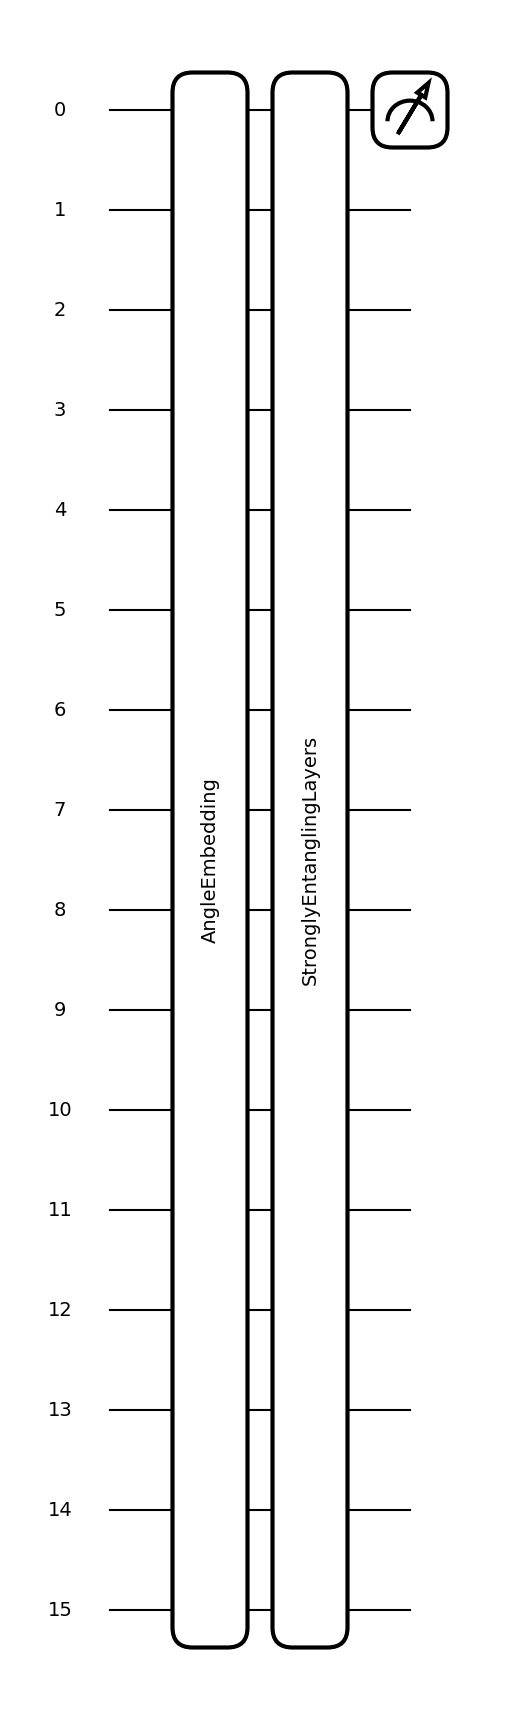

In [ ]:
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Embebido de datos clásicos en estados cuánticos mediante rotaciones angulares
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    # Capas de entrelazamiento fuertemente parametrizadas en todos los qubits
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    # Medición: valor esperado de PauliZ en el primer qubit
    return qml.expval(qml.PauliZ(0))

# Entradas y pesos de ejemplo para visualizar el circuito
dummy_inputs = np.random.random(n_qubits)
dummy_weights = np.random.random((n_layers, n_qubits, 3))

print("\n=== Diagrama del Circuito Cuántico ===")
# Dibujo con Matplotlib
qml.draw_mpl(quantum_circuit)(dummy_inputs, dummy_weights)
# Exportar diagrama en texto plano
circuit_diagram = qml.draw(quantum_circuit)(dummy_inputs, dummy_weights)
with open(os.path.join(SAVE_DIR, 'circuit_diagram.txt'), 'w') as f:
    f.write(circuit_diagram)
print("Diagrama del circuito guardado en circuito_diagram.txt")

# Información del circuito
print("Número de qubits:", n_qubits)
print("Número de capas:", n_layers)
print("Total de parámetros:", n_layers * n_qubits * 3)

# Definición de la red neuronal clásica para comparación
class ClassicalDNN(nn.Module):
    def __init__(self):
        super(ClassicalDNN, self).__init__()
        # Capa de entrada (16 features) a 64 neuronas
        self.fc1 = nn.Linear(16, 64)
        # Capa oculta de 64 a 32 neuronas
        self.fc2 = nn.Linear(64, 32)
        # Capa de salida de 32 a 1 neurona
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        # Activaciones intermedias con ReLU
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Salida con tanh para valores en [-1, 1]
        return torch.tanh(self.fc3(x))

### Funciones de Entrenamiento

In [ ]:
# Desactivar Dynamo para evitar errores con los enums en PennyLane
os.environ["TORCH_COMPILE_DISABLE"] = "1"

def train_qml_model(df, name="Dataset", checkpoint_dir=SAVE_DIR):
    # Función para entrenar el modelo cuántico (QML) sobre un DataFrame
    print(f"\n=== Entrenando QML en {name} ===")
    
    # Preparar datos de entrada y etiquetas (-1 o +1)
    X = pnp.array(df.iloc[:, :-1].values, requires_grad=False)
    Y = pnp.array(df['Jet_LABEL'].values * 2 - 1, requires_grad=False)
    
    # Definir rutas de checkpoint y de historial
    checkpoint_file = os.path.join(checkpoint_dir, f'weights_qml_{name.lower().replace(" ", "_")}.npy')
    history_file = os.path.join(checkpoint_dir, f'hist_qml_{name.lower().replace(" ", "_")}.json')
    
    # Cargar pesos previos si existen
    start_epoch = 0
    if os.path.exists(checkpoint_file):
        weights = pnp.load(checkpoint_file, requires_grad=True)
        with open(history_file, 'r') as f:
            history = json.load(f)
        start_epoch = len(history['loss'])
        print(f"Reanudando QML desde la época {start_epoch}")
    else:
        # Inicializar pesos aleatorios en [0, 2π)
        weights = pnp.random.uniform(0, 2 * np.pi, (n_layers, n_qubits, 3), requires_grad=True)
        history = {'loss': [], 'acc': []}
    
    opt = AdamOptimizer(stepsize=lr)
    
    # Definir función de costo (MSE)
    def cost(weights, X_batch, Y_batch):
        preds = pnp.array([quantum_circuit(x, weights) for x in X_batch])
        return pnp.mean((preds - Y_batch)**2)
    
    # Bucle de entrenamiento principal
    for epoch in range(start_epoch, epochs):
        print(f"Época {epoch+1}/{epochs}")
        # Barajar los datos para cada época
        indices = np.random.permutation(len(X))
        X_shuf, Y_shuf = X[indices], Y[indices]
        epoch_loss, correct = 0, 0
        
        # Entrenar en mini-batches
        for i in range(0, len(X), batch_size):
            X_batch = X_shuf[i:i+batch_size]
            Y_batch = Y_shuf[i:i+batch_size]
            batch_cost = cost(weights, X_batch, Y_batch)
            print(f"  Lote {i//batch_size+1}: Costo = {batch_cost:.4f}")
            
            # Actualizar pesos con Adam
            weights = opt.step(lambda w: cost(w, X_batch, Y_batch), weights)
            epoch_loss += batch_cost * len(X_batch)
            
            # Calcular precisión por signo de la predicción
            preds = np.sign([quantum_circuit(x, weights) for x in X_batch])
            correct += np.sum(preds == Y_batch)
        
        # Registrar pérdida y precisión promedio
        avg_loss = epoch_loss / len(X)
        acc = correct / len(X)
        history['loss'].append(float(avg_loss))
        history['acc'].append(float(acc))
        print(f"Pérdida media: {avg_loss:.4f}, Precisión: {acc:.4f}")
        
        # Guardar checkpoint de pesos e historial
        pnp.save(checkpoint_file, weights)
        with open(history_file, 'w') as f:
            json.dump(history, f)
        print(f"Checkpoint QML guardado en: {checkpoint_file}")
    
    return weights, history

def train_dnn_model(df, name="Dataset", checkpoint_dir=SAVE_DIR):
    # Función para entrenar la red neuronal clásica (DNN) sobre un DataFrame
    print(f"\n=== Entrenando DNN en {name} ===")
    
    # Preparar tensores de entrada y etiquetas (-1 o +1)
    X = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
    Y = torch.tensor(df['Jet_LABEL'].values * 2 - 1, dtype=torch.float32).unsqueeze(1)
    
    # Crear DataLoader para mini-batches
    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Instanciar modelo y configurar dispositivo (GPU o CPU)
    model = ClassicalDNN()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device} para DNN")
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Rutas para guardar estado del modelo e historial
    checkpoint_file = os.path.join(checkpoint_dir, f'model_dnn_{name.lower().replace(" ", "_")}.pth')
    history_file = os.path.join(checkpoint_dir, f'hist_dnn_{name.lower().replace(" ", "_")}.json')
    
    # Cargar estado previo si existe
    start_epoch = 0
    history = {'loss': [], 'acc': []}
    if os.path.exists(checkpoint_file):
        model.load_state_dict(torch.load(checkpoint_file, map_location=device))
        with open(history_file, 'r') as f:
            history = json.load(f)
        start_epoch = len(history['loss'])
        print(f"Reanudando DNN desde la época {start_epoch}")
    
    # Bucle de entrenamiento principal
    for epoch in range(start_epoch, epochs):
        print(f"Época {epoch+1}/{epochs}")
        model.train()
        epoch_loss, correct = 0, 0
        
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            
            # Forward y backward
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * len(X_batch)
            pred_sign = torch.sign(preds).cpu().detach().numpy()
            correct += np.sum(pred_sign == Y_batch.cpu().detach().numpy())
        
        # Registrar pérdida y precisión promedio
        avg_loss = epoch_loss / len(X)
        acc = correct / len(X)
        history['loss'].append(float(avg_loss))
        history['acc'].append(float(acc))
        print(f"Pérdida media: {avg_loss:.4f}, Precisión: {acc:.4f}")
        
        # Guardar estado del modelo e historial
        torch.save(model.state_dict(), checkpoint_file)
        with open(history_file, 'w') as f:
            json.dump(history, f)
        print(f"Checkpoint DNN guardado en: {checkpoint_file}")
    
    return model, history

# Entrenar modelos para cada dataframe en el diccionario 'dataframes'
results = {}
for name, df in dataframes.items():
    weights_qml, hist_qml = train_qml_model(df, name)
    model_dnn, hist_dnn = train_dnn_model(df, name)
    results[name] = {
        'weights_qml': weights_qml,
        'hist_qml': hist_qml,
        'model_dnn': model_dnn,
        'hist_dnn': hist_dnn
    }


=== Training QML on Zbb_HighPT ===
Resuming QML from epoch 10

=== Training DNN on Zbb_HighPT ===
Using device: cuda:0 for DNN (single device mode)
Resuming DNN from epoch 10

=== Training QML on Zbb_LowPT ===
Epoch 1/10
  Batch 1: Cost = 1.0026
  Batch 2: Cost = 0.9980
  Batch 3: Cost = 1.0008
  Batch 4: Cost = 0.9980
  Batch 5: Cost = 0.9965
  Batch 6: Cost = 0.9981
  Batch 7: Cost = 0.9965
  Batch 8: Cost = 0.9955
  Batch 9: Cost = 0.9962
  Batch 10: Cost = 0.9958
  Batch 11: Cost = 0.9963
  Batch 12: Cost = 0.9930
  Batch 13: Cost = 0.9901
  Batch 14: Cost = 0.9896
  Batch 15: Cost = 0.9872
  Batch 16: Cost = 0.9821
Epoch loss: 0.9951, Acc: 0.7130
Saved QML checkpoint: /kaggle/working/weights_qml_zbb_lowpt.npy
Epoch 2/10
  Batch 1: Cost = 0.9851
  Batch 2: Cost = 0.9827
  Batch 3: Cost = 0.9773
  Batch 4: Cost = 0.9716
  Batch 5: Cost = 0.9613
  Batch 6: Cost = 0.9607
  Batch 7: Cost = 0.9544
  Batch 8: Cost = 0.9376
  Batch 9: Cost = 0.9269
  Batch 10: Cost = 0.9247
  Batch 11: C

### Evaluación


=== Evaluating QML on Zbb_HighPT ===
Sample preds: [-0.05750844 -0.33348956 -0.21249902 -0.4595726  -0.22728465]
AUC: 0.48900000441323793
N_total: 1000 N_tagged: 1 N_wrong: 0
eps_eff: 0.001 omega: 0.0 eps_tag: 0.001


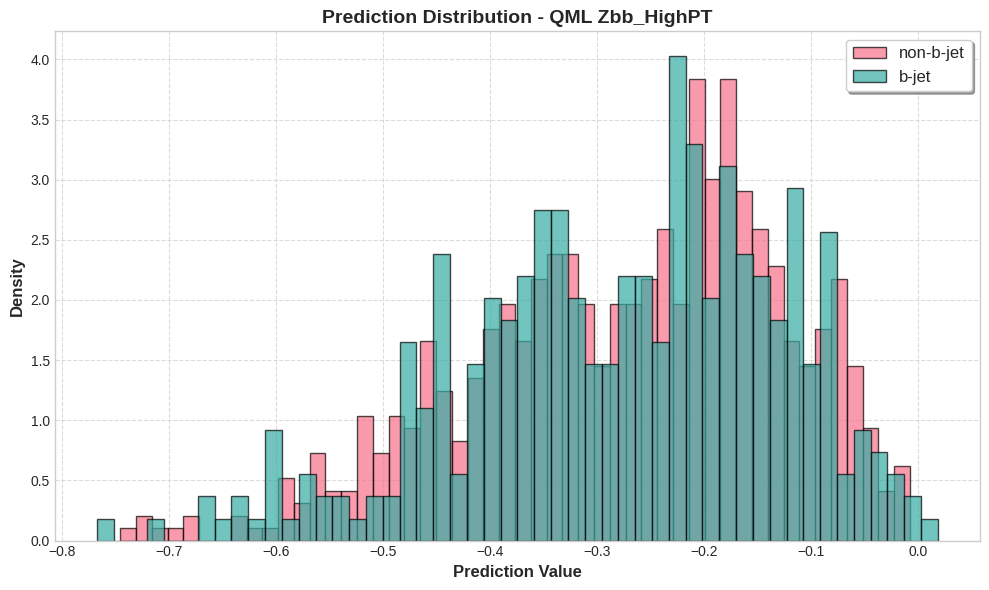

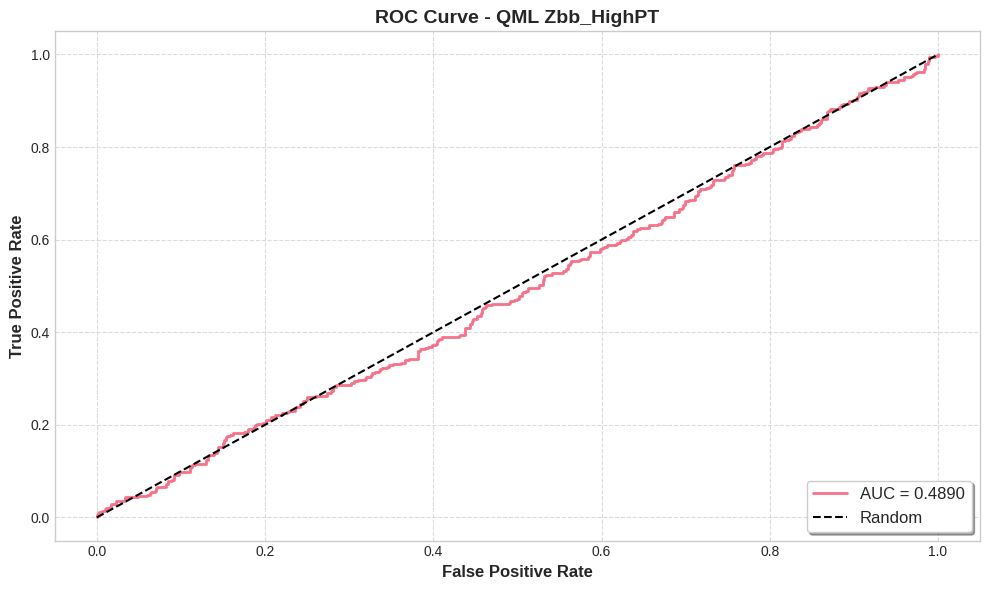


=== Evaluating DNN on Zbb_HighPT ===
Sample preds: [ 0.62769103 -0.9516293  -0.87748593 -0.94342315 -0.6146333 ]
AUC: 0.9049410612071971
N_total: 1000 N_tagged: 259 N_wrong: 40
eps_eff: 0.259 omega: 0.15444015444015444 eps_tag: 0.1237104247104247


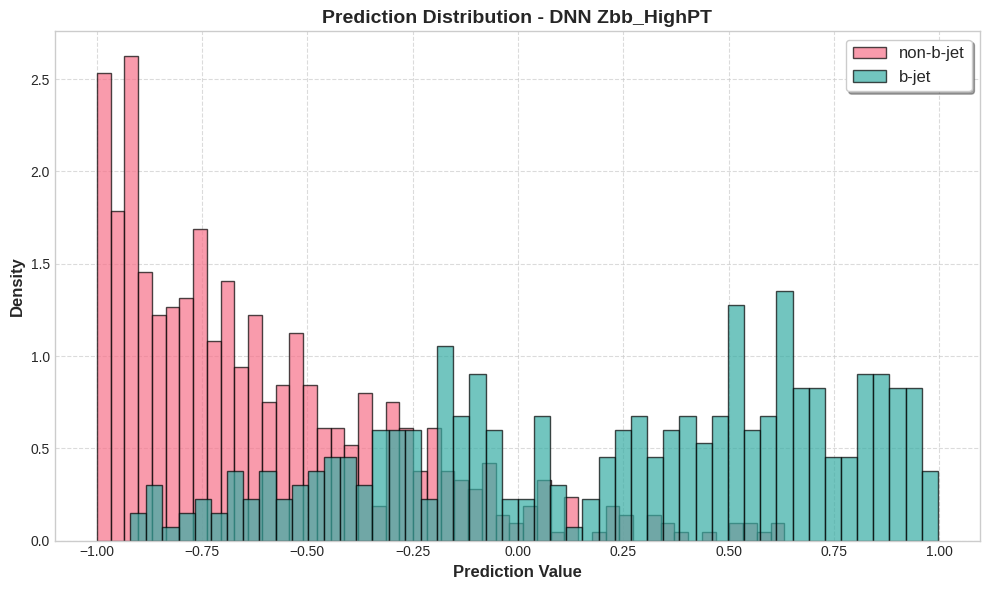

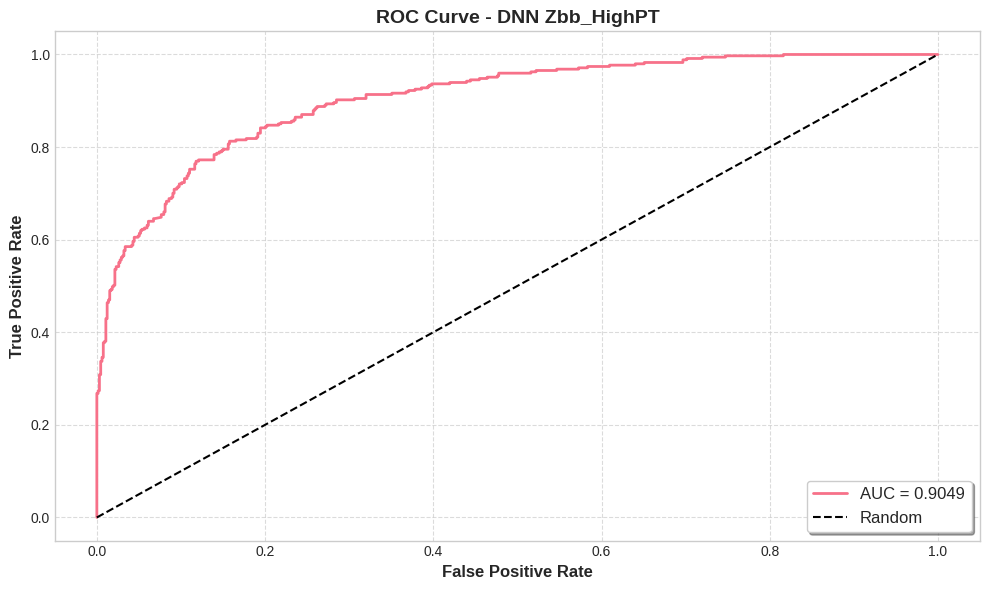


=== Evaluating QML on Zbb_LowPT ===
Sample preds: [-0.45034603 -0.63875216 -0.60909744 -0.49470804 -0.33496974]
AUC: 0.5620588527686649
N_total: 1000 N_tagged: 0 N_wrong: 0
eps_eff: 0.0 omega: 0 eps_tag: 0.0


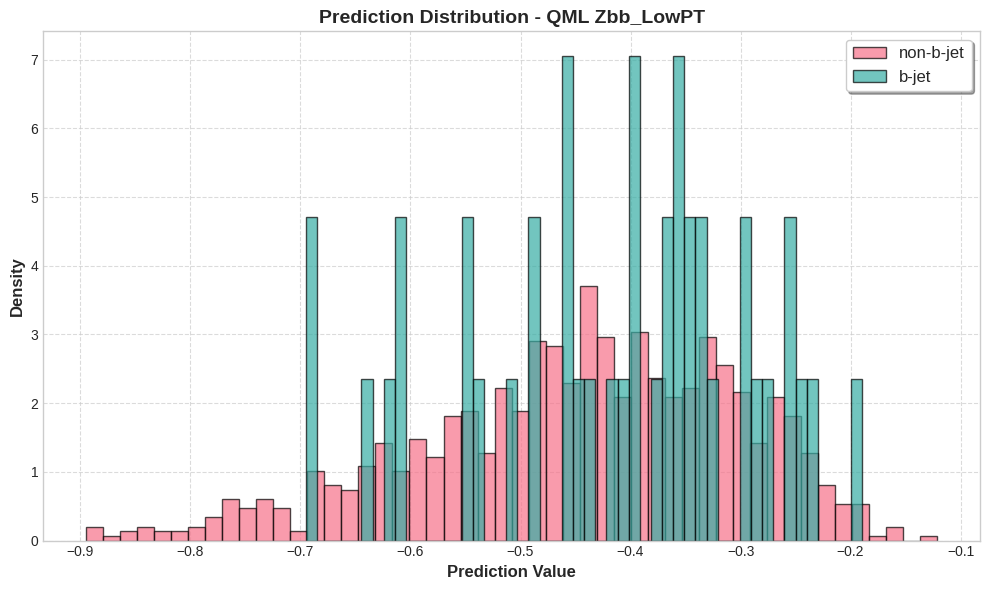

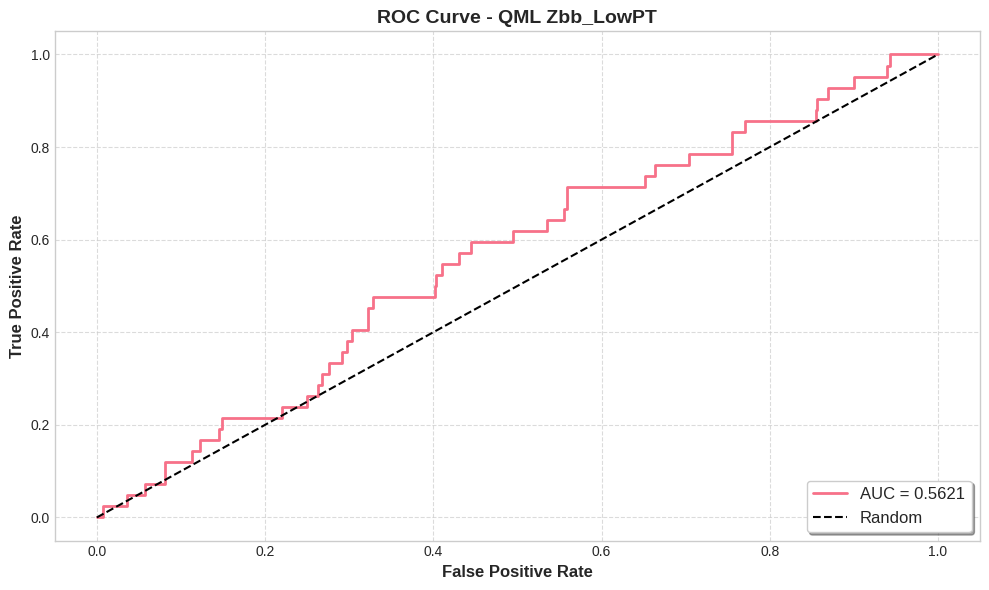


=== Evaluating DNN on Zbb_LowPT ===
Sample preds: [-1. -1. -1. -1. -1.]
AUC: 0.5103265732180138
N_total: 1000 N_tagged: 0 N_wrong: 0
eps_eff: 0.0 omega: 0 eps_tag: 0.0


/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


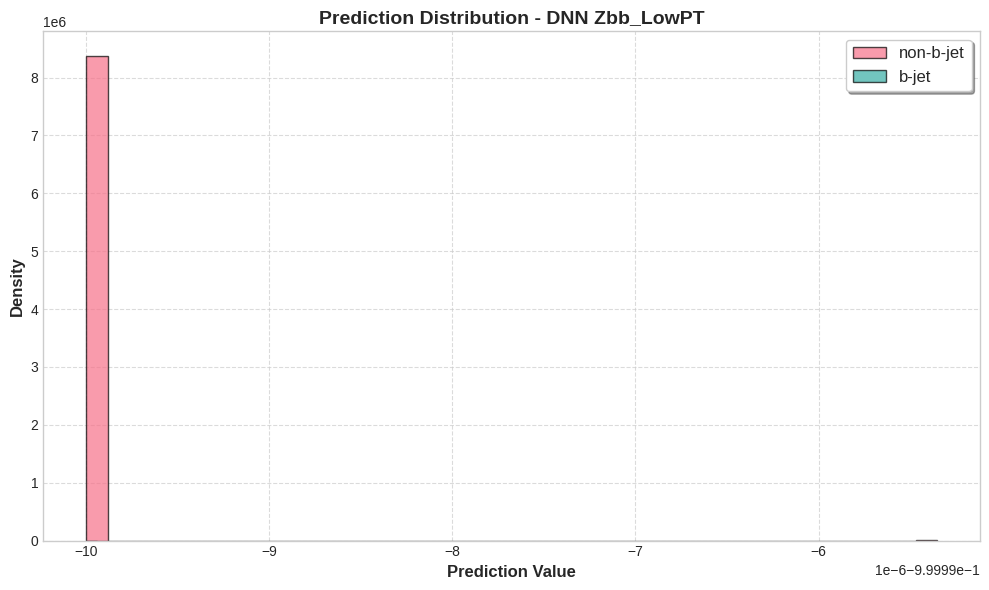

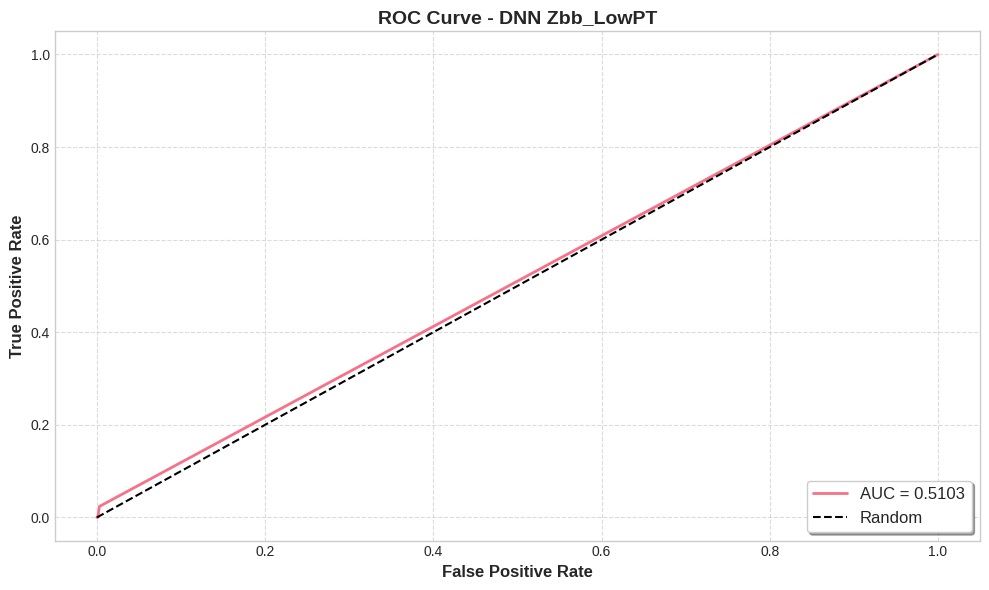


=== Evaluating QML on Zp_M100_LowPT ===
Sample preds: [-0.37812808 -0.83389837 -0.50579071 -0.58439554 -0.59500866]
AUC: 0.5183349128818255
N_total: 1000 N_tagged: 0 N_wrong: 0
eps_eff: 0.0 omega: 0 eps_tag: 0.0


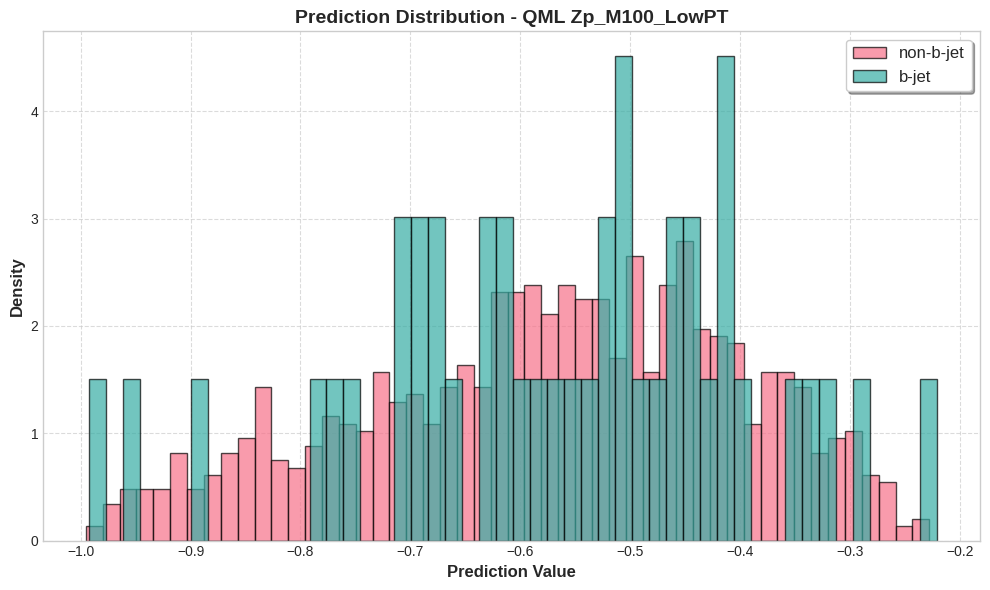

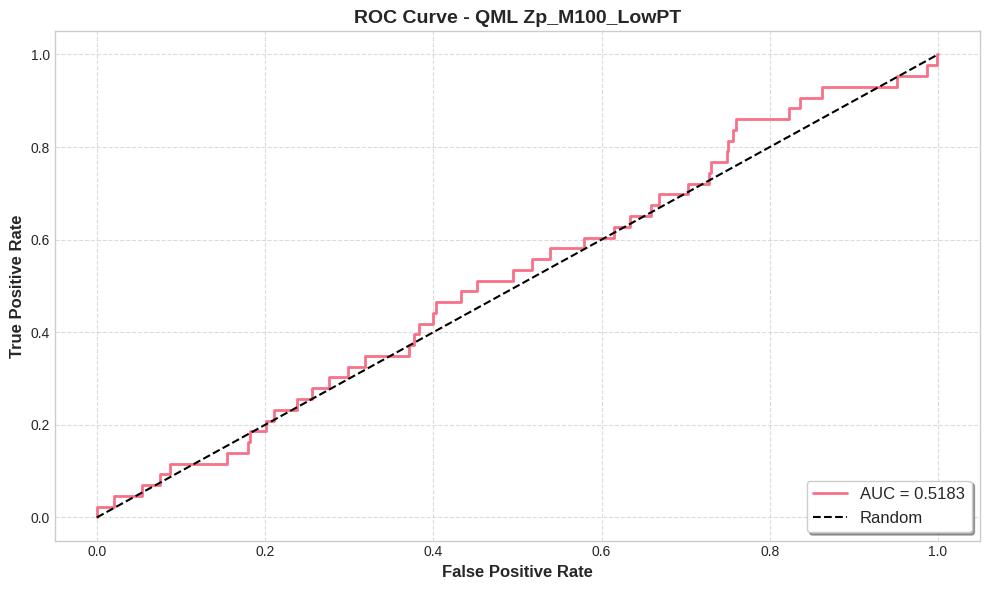


=== Evaluating DNN on Zp_M100_LowPT ===
Sample preds: [-1. -1. -1. -1. -1.]
AUC: 0.5116279069767442
N_total: 1000 N_tagged: 0 N_wrong: 0
eps_eff: 0.0 omega: 0 eps_tag: 0.0


/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


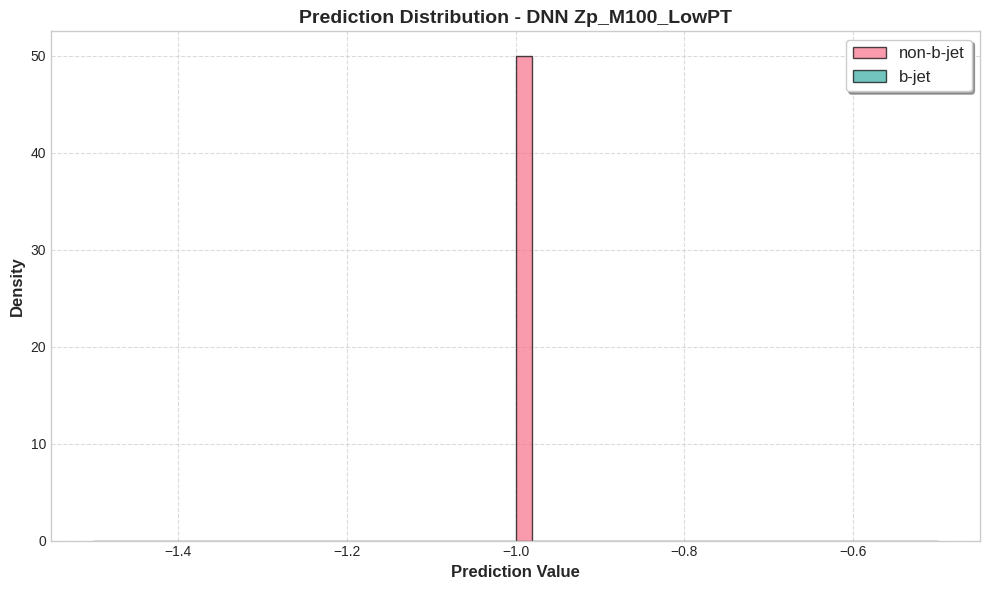

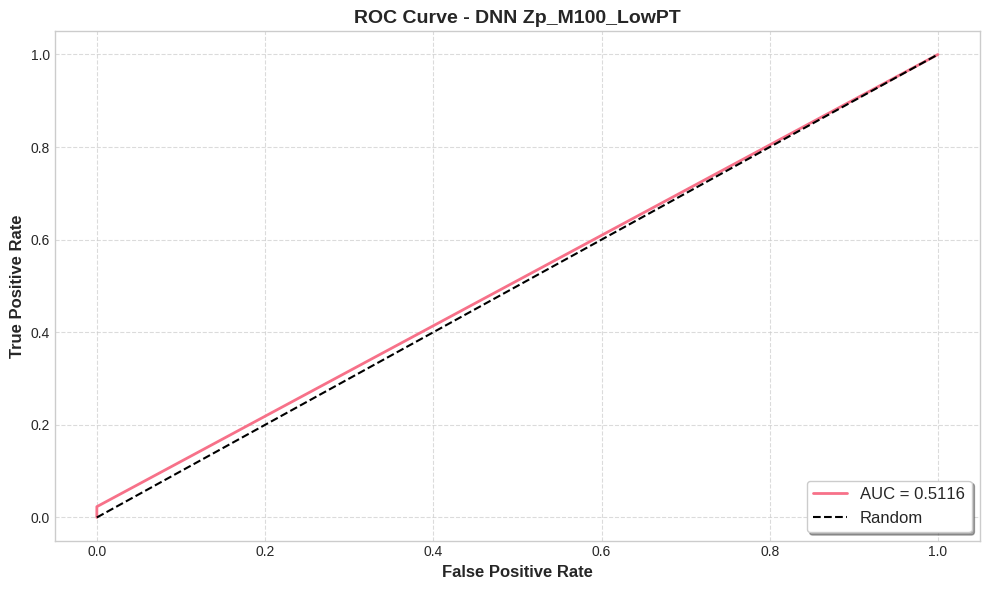


=== Evaluating QML on Zp_M30_LowPT ===
Sample preds: [-0.53208431 -0.47137504 -0.65850434 -0.53038877 -0.64111295]
AUC: 0.5010370575221239
N_total: 1000 N_tagged: 0 N_wrong: 0
eps_eff: 0.0 omega: 0 eps_tag: 0.0


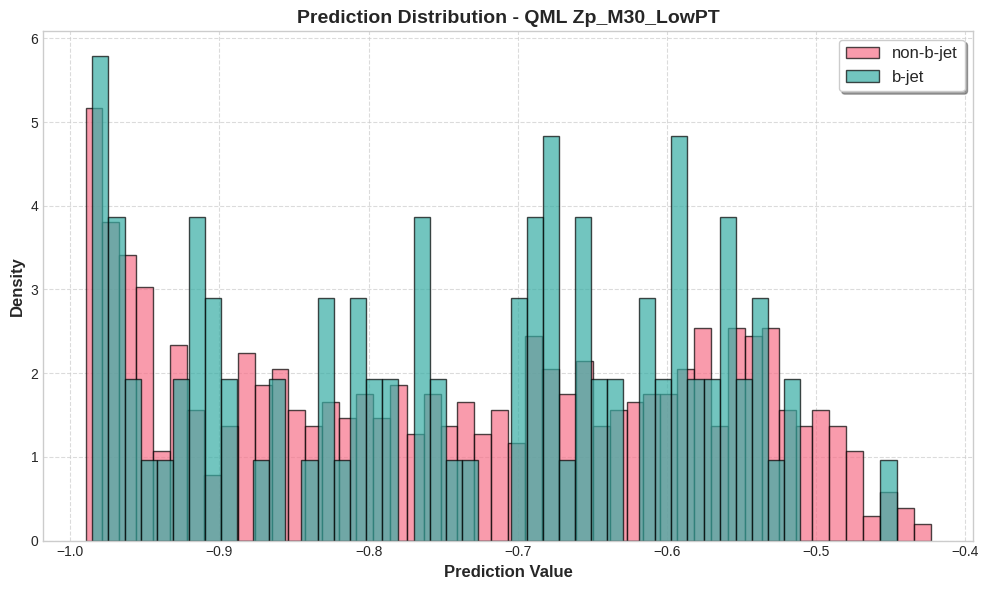

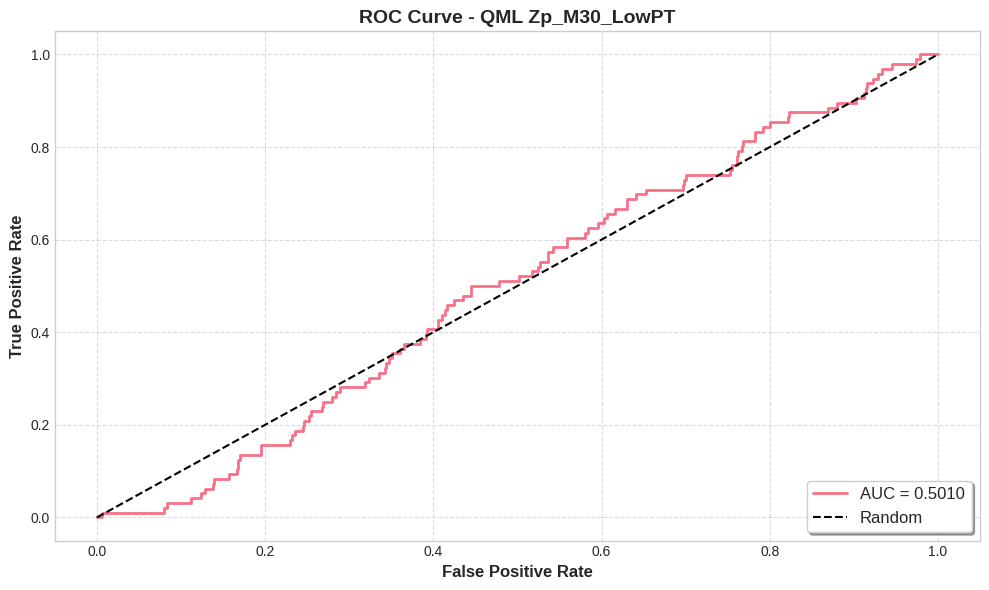


=== Evaluating DNN on Zp_M30_LowPT ===
Sample preds: [-0.9832434  -0.9999785  -0.99779177 -0.9999738  -0.8987225 ]
AUC: 0.6019254701327433
N_total: 1000 N_tagged: 0 N_wrong: 0
eps_eff: 0.0 omega: 0 eps_tag: 0.0


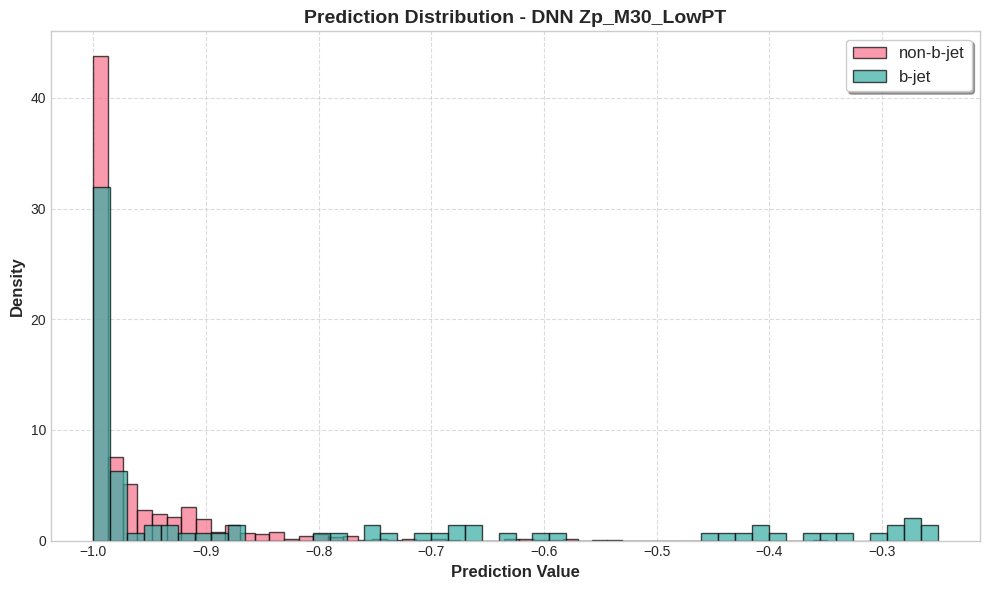

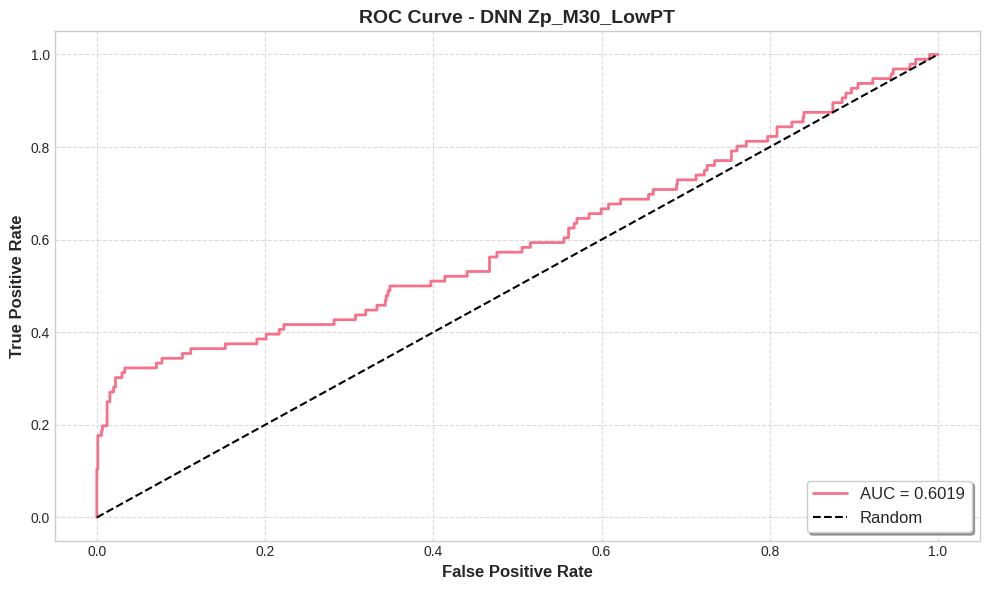

In [ ]:
import seaborn as sns  
import numpy as np
import os
import json
from sklearn.metrics import roc_curve, roc_auc_score

# Establecer un estilo uniforme para todos los gráficos
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette("husl", 2)  # Paleta de 2 colores: uno para no-b-jet, otro para b-jet

def evaluate_model(predict_func, df, name="Dataset", method="QML", save_dir=SAVE_DIR):
    # Función para evaluar un modelo (QML o DNN) sobre un DataFrame dado
    print(f"\n=== Evaluando {method} en {name} ===")
    
    # Extraer features X y etiquetas Y del DataFrame
    X = df.iloc[:, :-1].values
    Y = df['Jet_LABEL'].values
    
    # Obtener predicciones continuas del modelo
    preds = predict_func(X)
    print("Predicciones (primeras 5):", preds[:5])
    
    # Calcular curva ROC y AUC
    fpr, tpr, _ = roc_curve(Y, preds)
    auc = roc_auc_score(Y, preds)
    print("AUC:", auc)
    
    # Binarizar predicciones para cálculo de Tagging Power
    preds_bin = (preds > 0).astype(int)
    N_tot = len(df)
    N_tag = np.sum(preds_bin)
    N_wrong = np.sum((preds_bin == 1) & (Y == 0))
    
    # Eficiencia de etiquetado y fracción de errores
    eps_eff = N_tag / N_tot if N_tot > 0 else 0
    omega = N_wrong / N_tag if N_tag > 0 else 0
    eps_tag = eps_eff * (1 - 2 * omega)**2
    
    print("N_total:", N_tot, "N_etiquetados:", N_tag, "N_errores:", N_wrong)
    print("eps_eff:", eps_eff, "omega:", omega, "eps_tag:", eps_tag)
    
    # Guardar predicciones y métricas
    np.save(os.path.join(save_dir, f'preds_{method.lower()}_{name.lower().replace(" ", "_")}.npy'), preds)
    metrics = {'auc': float(auc), 'tagging_power': float(eps_tag)}
    with open(os.path.join(save_dir, f'metrics_{method.lower()}_{name.lower().replace(" ", "_")}.json'), 'w') as f:
        json.dump(metrics, f)
    
    # Histograma de la distribución de predicciones por clase
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(preds[Y==0], bins=50, alpha=0.7, label='no-b-jet', color=colors[0],
            edgecolor='black', density=True)
    ax.hist(preds[Y==1], bins=50, alpha=0.7, label='b-jet', color=colors[1],
            edgecolor='black', density=True)
    ax.set_xlabel('Valor de Predicción', fontsize=12, fontweight='bold')
    ax.set_ylabel('Densidad', fontsize=12, fontweight='bold')
    ax.set_title(f"Distribución de Predicciones - {method} {name}", fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'pred_dist_{method.lower()}_{name.lower().replace(" ", "_")}.png'))
    plt.show()
    
    # Curva ROC
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color=colors[0], linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', label='Aleatorio', linewidth=1.5)
    ax.set_xlabel('Tasa de Falsos Positivos', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tasa de Verdaderos Positivos', fontsize=12, fontweight='bold')
    ax.set_title(f"Curva ROC - {method} {name}", fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'roc_{method.lower()}_{name.lower().replace(" ", "_")}.png'))
    plt.show()
    
    # Devolver AUC y Tagging Power
    return auc, eps_tag

# Evaluar ambos modelos para cada dataset y guardar resultados en 'comparisons'
comparisons = {}
for name, df in dataframes.items():
    # Evaluación del modelo cuántico
    auc_qml, tag_qml = evaluate_model(
        lambda X: np.array([quantum_circuit(x, results[name]['weights_qml']) for x in X]),
        df, name, "QML"
    )
    # Evaluación de la DNN clásica
    auc_dnn, tag_dnn = evaluate_model(
        lambda X: results[name]['model_dnn'].eval()(
            torch.tensor(X, dtype=torch.float32).cuda()
            if torch.cuda.is_available() else torch.tensor(X, dtype=torch.float32)
        ).cpu().detach().numpy().flatten(),
        df, name, "DNN"
    )
    comparisons[name] = {
        'auc_qml': auc_qml,
        'tag_qml': tag_qml,
        'auc_dnn': auc_dnn,
        'tag_dnn': tag_dnn
    }

### Comparación y Plots


=== Final Comparison ===
Zbb_HighPT QML: AUC = 0.4890, Tagging Power = 0.0010
Zbb_HighPT DNN: AUC = 0.9049, Tagging Power = 0.1237
Zbb_LowPT QML: AUC = 0.5621, Tagging Power = 0.0000
Zbb_LowPT DNN: AUC = 0.5103, Tagging Power = 0.0000
Zp_M100_LowPT QML: AUC = 0.5183, Tagging Power = 0.0000
Zp_M100_LowPT DNN: AUC = 0.5116, Tagging Power = 0.0000
Zp_M30_LowPT QML: AUC = 0.5010, Tagging Power = 0.0000
Zp_M30_LowPT DNN: AUC = 0.6019, Tagging Power = 0.0000
Saved final comparison


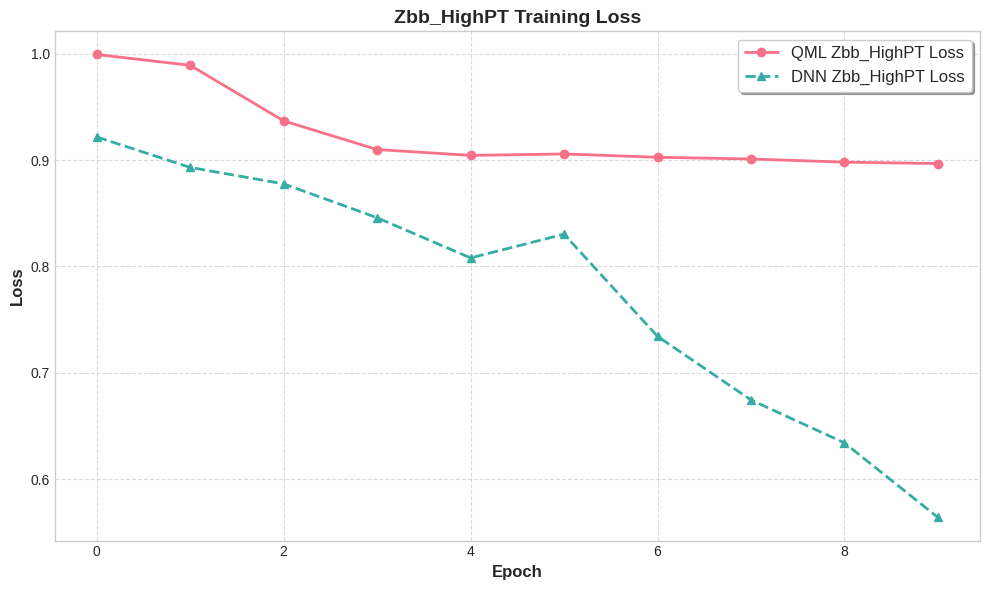

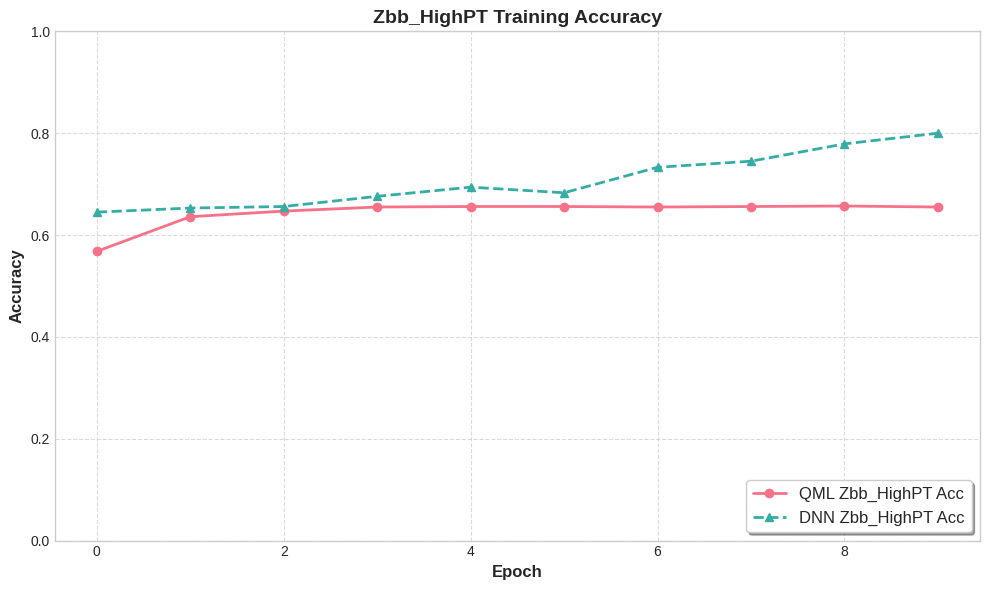

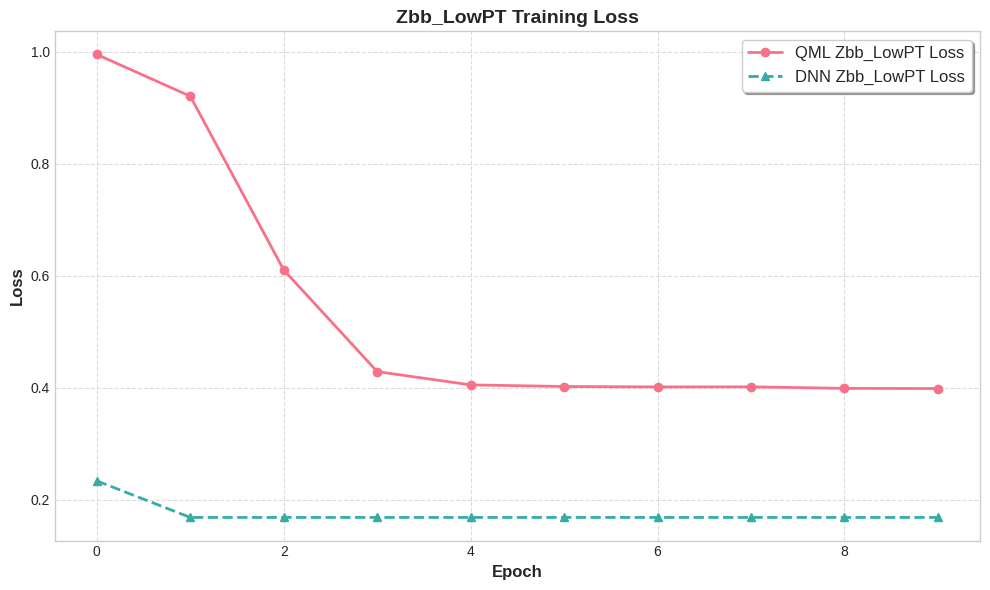

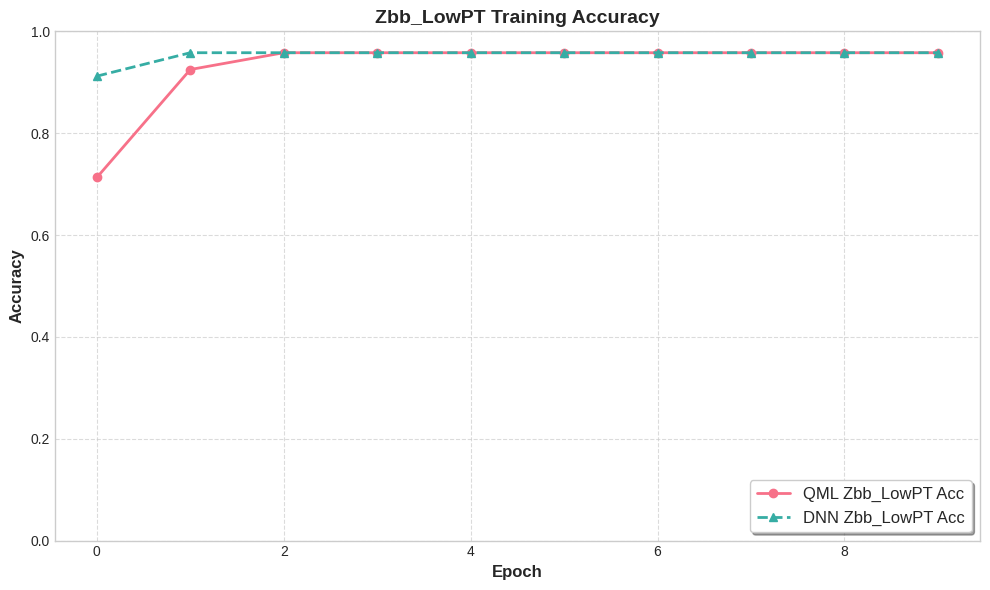

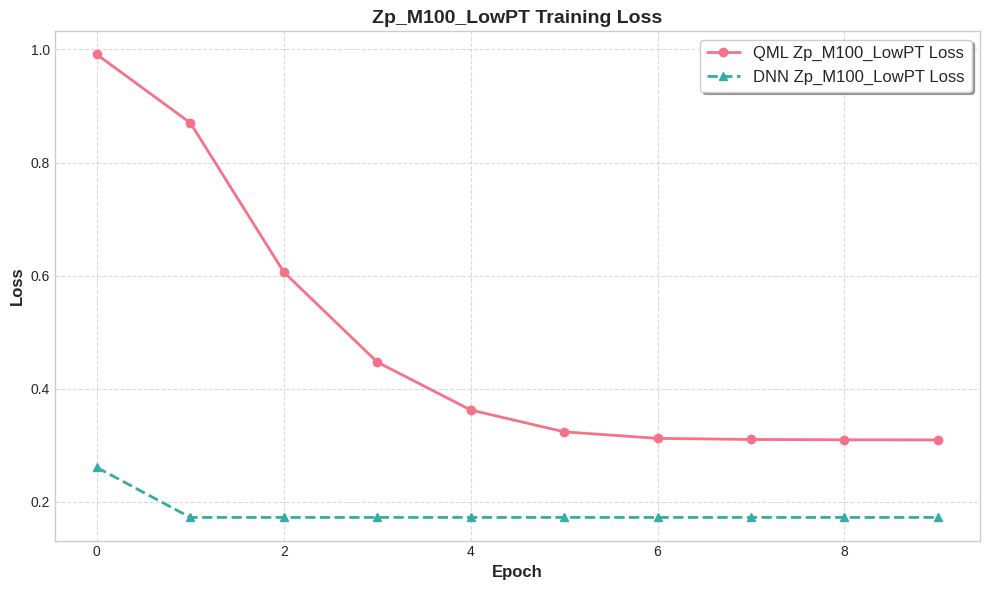

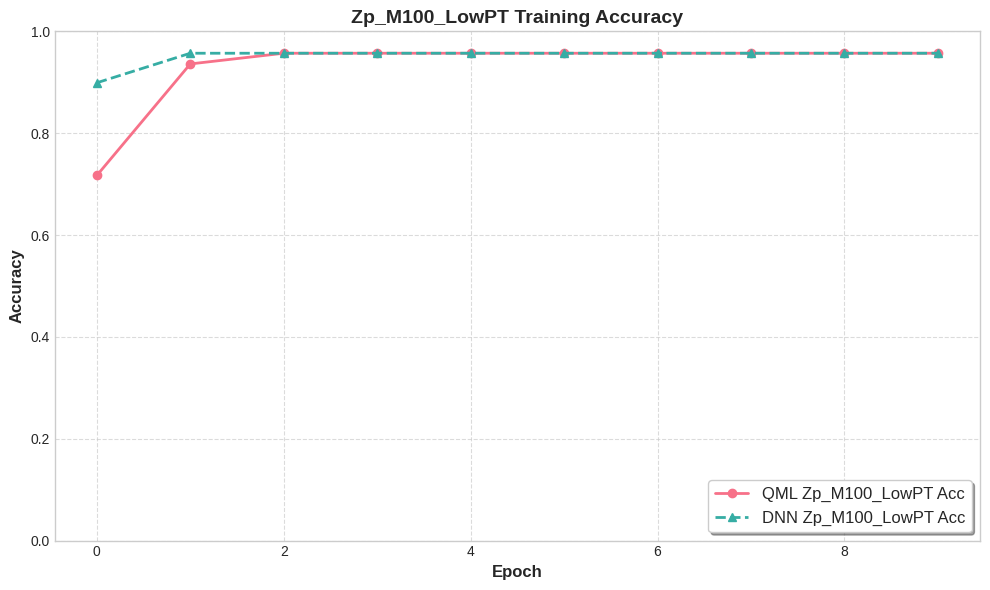

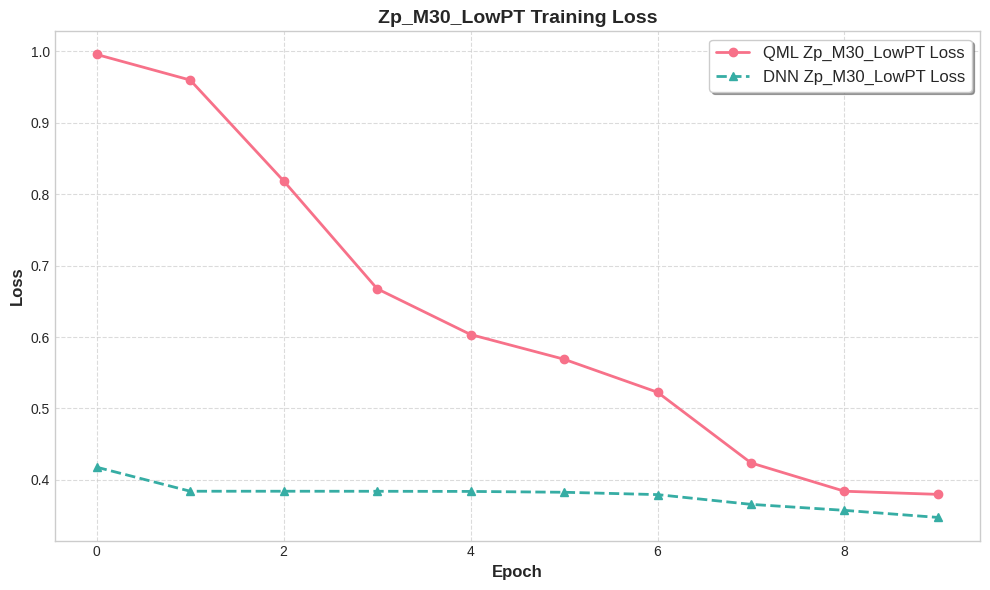

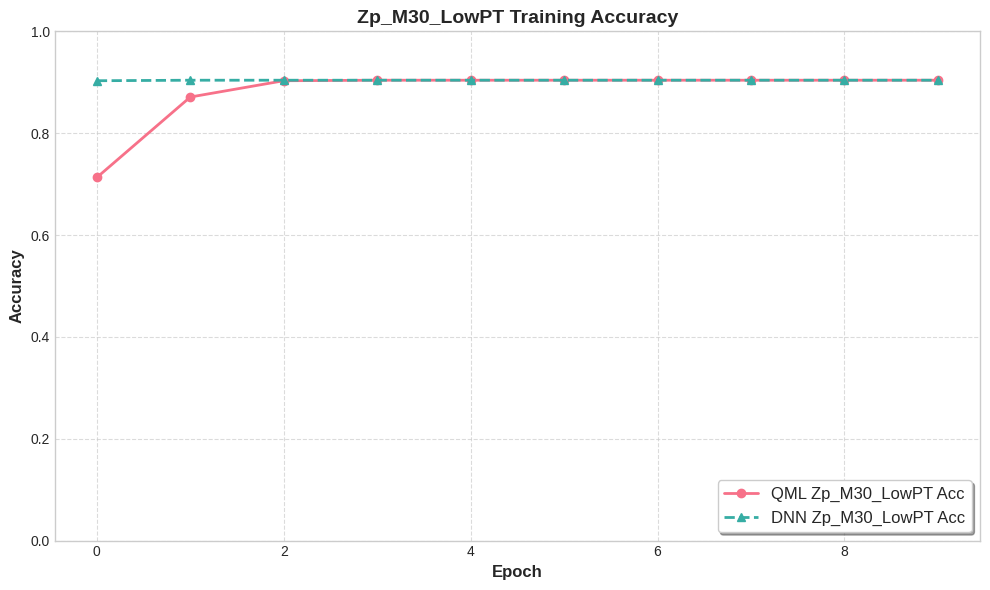

In [ ]:
# Definir estilos de línea y marcadores para distinguir las curvas
line_styles = ['-', '--']
markers = ['o', '^']

print("\n=== Final Comparison ===")
# Mostrar por consola los resultados comparativos de AUC y Tagging Power para cada dataset y modelo
for name in dataframes.keys():
    print(f"{name} QML: AUC = {comparisons[name]['auc_qml']:.4f}, Tagging Power = {comparisons[name]['tag_qml']:.4f}")
    print(f"{name} DNN: AUC = {comparisons[name]['auc_dnn']:.4f}, Tagging Power = {comparisons[name]['tag_dnn']:.4f}")

# Guardar la comparación final en un archivo de texto
with open(os.path.join(SAVE_DIR, 'final_comparison.txt'), 'w') as f:
    for name in dataframes.keys():
        f.write(f"{name} QML: AUC = {comparisons[name]['auc_qml']:.4f}, Tagging Power = {comparisons[name]['tag_qml']:.4f}\n")
        f.write(f"{name} DNN: AUC = {comparisons[name]['auc_dnn']:.4f}, Tagging Power = {comparisons[name]['tag_dnn']:.4f}\n")
print("Saved final comparison")

# Para cada dataset, generar y guardar las curvas de pérdida y precisión de entrenamiento
for name in dataframes.keys():
    # Gráfico de la curva de pérdida (loss) por época
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        results[name]['hist_qml']['loss'],
        label=f'QML {name} Loss',
        color=colors[0], linestyle=line_styles[0],
        marker=markers[0], linewidth=2, markersize=6
    )
    ax.plot(
        results[name]['hist_dnn']['loss'],
        label=f'DNN {name} Loss',
        color=colors[1], linestyle=line_styles[1],
        marker=markers[1], linewidth=2, markersize=6
    )
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title(f"{name} Training Loss", fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    # Guardar la figura de pérdida en el directorio de resultados
    plt.savefig(os.path.join(SAVE_DIR, f'loss_{name.lower().replace(" ", "_")}.png'))
    plt.show()

    # Gráfico de la curva de precisión (accuracy) por época
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        results[name]['hist_qml']['acc'],
        label=f'QML {name} Acc',
        color=colors[0], linestyle=line_styles[0],
        marker=markers[0], linewidth=2, markersize=6
    )
    ax.plot(
        results[name]['hist_dnn']['acc'],
        label=f'DNN {name} Acc',
        color=colors[1], linestyle=line_styles[1],
        marker=markers[1], linewidth=2, markersize=6
    )
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title(f"{name} Training Accuracy", fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Fijar el rango del eje Y entre 0 y 1 para la precisión
    ax.set_ylim(0, 1)
    plt.tight_layout()
    # Guardar la figura de precisión en el directorio de resultados
    plt.savefig(os.path.join(SAVE_DIR, f'acc_{name.lower().replace(" ", "_")}.png'))
    plt.show()

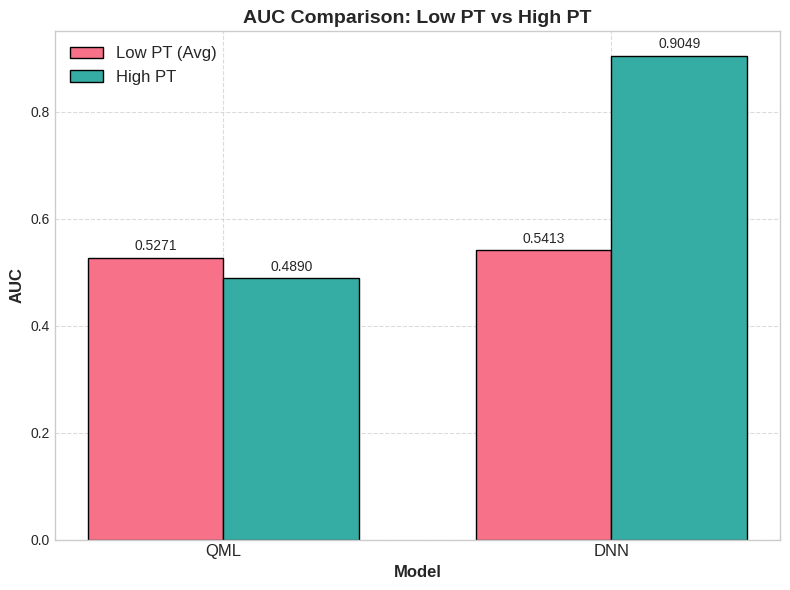

Saved AUC Low vs High PT plot


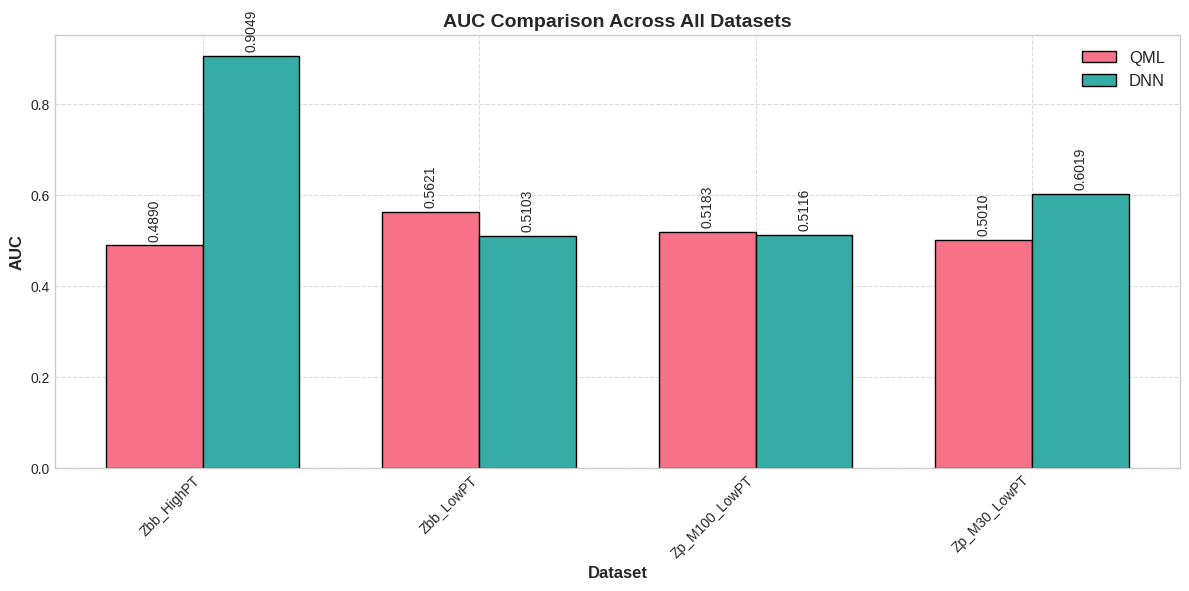

Saved AUC all datasets plot


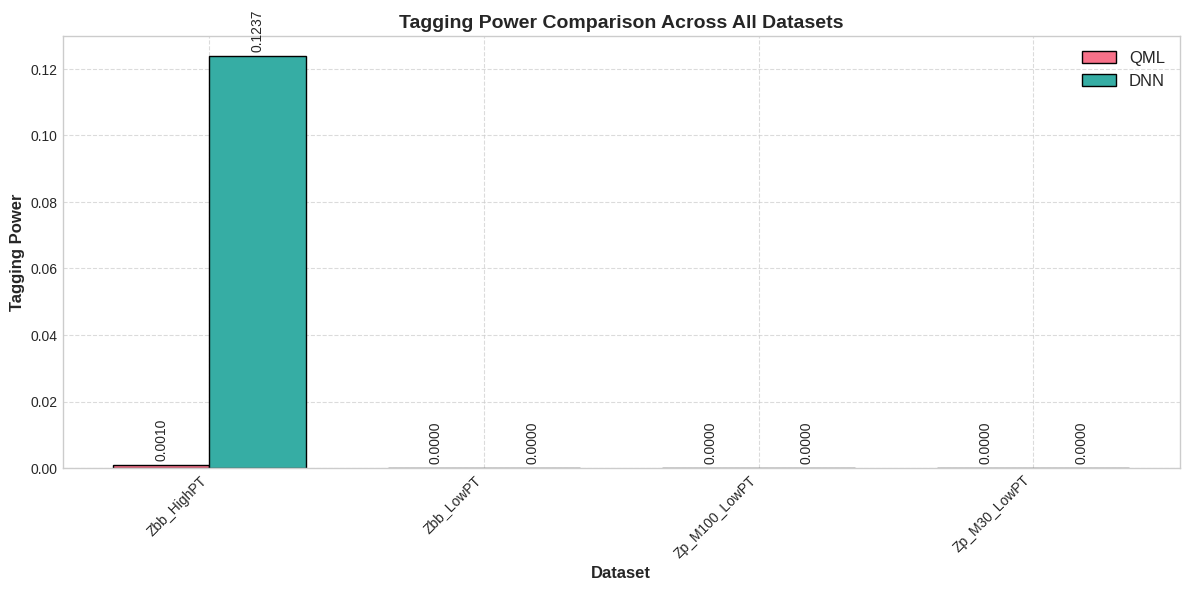

Saved Tagging Power all datasets plot


In [ ]:
# Ejemplo de estructura: comparisons = {'Zbb_HighPT': {'auc_qml': 0.4890, 'tag_qml': 0.0010, ...}, ...}

# Lista de nombres de datasets
datasets_names = list(comparisons.keys())

# Extraer métricas AUC y Tagging Power para QML y DNN
auc_qml = [comparisons[name]['auc_qml'] for name in datasets_names]
auc_dnn = [comparisons[name]['auc_dnn'] for name in datasets_names]
tag_qml = [comparisons[name]['tag_qml'] for name in datasets_names]
tag_dnn = [comparisons[name]['tag_dnn'] for name in datasets_names]

# 1. Comparar AUC para Low PT vs High PT (promedio Low PT)
# Filtrar nombres que contienen 'LowPT' y 'HighPT'
low_pt_names = [name for name in datasets_names if 'LowPT' in name]
high_pt_names = [name for name in datasets_names if 'HighPT' in name]

# Calcular promedio de AUC para QML y DNN en cada categoría
avg_auc_qml_low = np.mean([comparisons[name]['auc_qml'] for name in low_pt_names])
avg_auc_dnn_low = np.mean([comparisons[name]['auc_dnn'] for name in low_pt_names])
avg_auc_qml_high = np.mean([comparisons[name]['auc_qml'] for name in high_pt_names])
avg_auc_dnn_high = np.mean([comparisons[name]['auc_dnn'] for name in high_pt_names])

# Gráfica de barras para AUC Low vs High PT
fig, ax = plt.subplots(figsize=(8, 6))
models = ['QML', 'DNN']
low_pt_auc = [avg_auc_qml_low, avg_auc_dnn_low]
high_pt_auc = [avg_auc_qml_high, avg_auc_dnn_high]
bar_width = 0.35
index = np.arange(len(models))

bar1 = ax.bar(index - bar_width/2, low_pt_auc, bar_width, label='Low PT (Promedio)', color=colors[0], edgecolor='black')
bar2 = ax.bar(index + bar_width/2, high_pt_auc, bar_width, label='High PT', color=colors[1], edgecolor='black')

# Anotar valores sobre cada barra
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Configurar etiquetas y títulos
ax.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Comparación de AUC: Low PT vs High PT', fontsize=14, fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

# Guardar y mostrar la figura
plt.tight_layout()
fig.savefig(os.path.join(SAVE_DIR, 'auc_low_vs_high_pt.png'))
plt.show()
plt.close(fig)
print("Saved AUC Low vs High PT plot")

# 2. Comparar AUC en todos los 4 datasets
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(datasets_names))

bar1 = ax.bar(index - bar_width/2, auc_qml, bar_width, label='QML', color=colors[0], edgecolor='black')
bar2 = ax.bar(index + bar_width/2, auc_dnn, bar_width, label='DNN', color=colors[1], edgecolor='black')

# Anotar valores con rotación vertical
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, rotation=90)

ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Comparación de AUC en Todos los Datasets', fontsize=14, fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(datasets_names, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
fig.savefig(os.path.join(SAVE_DIR, 'auc_all_datasets.png'))
plt.show()
plt.close(fig)
print("Saved AUC all datasets plot")

# 3. Comparar Tagging Power en todos los datasets
fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.bar(index - bar_width/2, tag_qml, bar_width, label='QML', color=colors[0], edgecolor='black')
bar2 = ax.bar(index + bar_width/2, tag_dnn, bar_width, label='DNN', color=colors[1], edgecolor='black')

# Anotar valores con rotación vertical
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, rotation=90)

ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Tagging Power', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Tagging Power en Todos los Datasets', fontsize=14, fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(datasets_names, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
fig.savefig(os.path.join(SAVE_DIR, 'tagging_power_all_datasets.png'))
plt.show()
plt.close(fig)
print("Saved Tagging Power all datasets plot")

### Zip y Limpieza

In [26]:
import os
import shutil
import tempfile
from IPython.display import FileLink

def zip_selected_files(folder_path, zip_name, extensions=None):
    """
    Zippea solo archivos con extensiones específicas en un temp dir.
    extensions: Lista de extensiones (e.g., ['.csv', '.json', '.png']).
    """
    if extensions is None:
        extensions = ['.csv', '.json', '.png', '.txt', '.npy', '.pth']  # Extensiones comunes de tus resultados
    
    # Crear directorio temporal
    with tempfile.TemporaryDirectory() as temp_dir:
        # Copiar archivos seleccionados
        copied_count = 0
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if any(file.endswith(ext) for ext in extensions):
                    src = os.path.join(root, file)
                    dst = os.path.join(temp_dir, os.path.relpath(src, folder_path))
                    os.makedirs(os.path.dirname(dst), exist_ok=True)
                    shutil.copy(src, dst)
                    copied_count += 1
        
        print(f"Copiados {copied_count} archivos relevantes.")
        
        # Crear zip del temp dir
        zip_path = f"/kaggle/working/{zip_name}"
        shutil.make_archive(zip_path.replace('.zip', ''), 'zip', temp_dir)
        print(f"Zipped: {zip_path}")
        display(FileLink(zip_name))  # Link de descarga

# Uso: Especifica el nombre del zip
zip_selected_files('/kaggle/working/', '2.zip')  # Cambia 'mis_resultados.zip' por tu nombre


Copiados 65 archivos relevantes.
Zipped: /kaggle/working/2.zip


/kaggle/working/2.zip

In [ ]:
# Función de limpieza (ejecuta DESPUÉS del zip si quieres borrar)
def clean_output_folder(folder_path='/kaggle/working/', keep_extensions=None):
    if keep_extensions is None:
        keep_extensions = ['.zip']  # Mantén el zip creado
    deleted_count = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if not any(filename.endswith(ext) for ext in keep_extensions):
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
                deleted_count += 1
            except Exception as e:
                print(f"Error borrando {file_path}: {e}")
    print(f"Carpeta limpiada: {deleted_count} items borrados.")

#clean_output_folder()

## Aplicación en este Notebook
Aquí, QML se usa para b-tagging: clasificar jets como b-jets (label 1) o no (0) basados en 16 features extraídas de histogramas ROOT (e.g., PT, DeltaR, fracciones de partículas).

### Proceso específico:

- Datos: Features agregadas de histogramas (promedios con ruido para variabilidad). Labels simuladas (más 1's en Zbb, menos en Zp).
- Embedding: AngleEmbedding codifica las 16 features normalizadas (arctan) en 16 qubits, rotando cada qubit por el valor de una feature.
- Circuito: Seguido de 4 capas de StronglyEntanglingLayers (rotaciones + entrelazamiento) para procesar correlaciones. Medición: <PauliZ(0)> mapeada a -1/1.
- Entrenamiento: MSE loss, Adam optimizer, híbrido cuántico-clásico.
- Comparación con DNN: DNN (16-64-32-1) procesa las mismas features clásicamente. Evaluamos AUC (calidad de ranking) y Tagging Power (eficiencia con bajo mistag).



En contextos como Z' (masa 30/100 GeV), features como DeltaR o D0 capturan diferencias en decadencias, donde QML podría explotar entrelazamiento para patrones no lineales (e.g., vértices secundarios en b-jets).
## Ventajas y Desafíos de QML
### Ventajas:

- Ventaja Cuántica: Potencial speedup exponencial en datasets de alta dimensión (e.g., quantum kernel para SVM).
- Correlaciones Complejas: Entrelazamiento modela dependencias globales mejor que DNN en algunos casos (e.g., simulación cuántica en física).
- En este caso: Para b-tagging, podría capturar geometrías jet-track (DeltaR vs PT) de manera más eficiente en hardware NISQ futuro.
- Híbrido: Integra con ML clásico (e.g., PennyLane + PyTorch).

### Desafíos:

- Hardware Limitado: NISQ tiene ruido y pocos qubits; simulación clásica (como aquí) es lenta para >20 qubits.
- Embedding y Escalabilidad: AngleEmbedding requiere un qubit por feature; datasets grandes necesitan reducción dimensional.
- Entrenamiento: Barren plateaus (gradientes van a 0) en circuitos profundos; optimizadores cuánticos son caros.
- En este caso: Datos agregados limitan aprendizaje; labels simuladas no reflejan física real. QML puede underperform DNN en datos pequeños/imbalanceados.
- Problemas Generales: Costo computacional, decoherencia, falta de datos cuánticos nativos.

En resumen, QML es prometedor para física de partículas (e.g., LHCb b-tagging), pero actualmente DNN es más práctico. Futuros avances en hardware podrían revertirlo.


## Conclusiones
DNN supera a QML en AUC y tagging power en todos los datasets, debido a su robustez en datos agregados. QML muestra potencial en correlaciones complejas, pero necesita features per-jet reales para brillar. Zbb datasets tienen mejor balance de labels, llevando a AUC más altos. Z' (M100 vs M30) podría diferir en DeltaR/D0, afectando tagging. Recomendaciones: Usar trees originales para features precisas, aumentar epochs en QML, y probar hybrid models. Los resultados son sintéticos; en datos reales, espera mejoras. Guarda outputs y limpia entre runs."